In [124]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics

import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [125]:
from pyspark.sql import SparkSession

In [126]:
spark=SparkSession.builder.appName('bigdata').getOrCreate()

In [127]:
spark

In [128]:
df=spark.read.csv('card_transdata.csv',header=True,inferSchema=True)

In [129]:
df.show()

+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
|distance_from_home|distance_from_last_transaction|ratio_to_median_purchase_price|repeat_retailer|used_chip|used_pin_number|online_order|fraud|
+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
| 57.87785658389723|            0.3111400080477545|            1.9459399775518593|            1.0|      1.0|            0.0|         0.0|  0.0|
|10.829942699255545|           0.17559150228166587|            1.2942188106198573|            1.0|      0.0|            0.0|         0.0|  0.0|
| 5.091079490616996|            0.8051525945853258|           0.42771456119427587|            1.0|      0.0|            0.0|         1.0|  0.0|
|2.2475643282963613|              5.60004354707232|           0.36266257805709584|            1.0|      1.0|            0.0|         1.0

In [130]:
type(df)

pyspark.sql.dataframe.DataFrame

In [131]:
df.head(2)

[Row(distance_from_home=57.87785658389723, distance_from_last_transaction=0.3111400080477545, ratio_to_median_purchase_price=1.9459399775518593, repeat_retailer=1.0, used_chip=1.0, used_pin_number=0.0, online_order=0.0, fraud=0.0),
 Row(distance_from_home=10.829942699255545, distance_from_last_transaction=0.17559150228166587, ratio_to_median_purchase_price=1.2942188106198573, repeat_retailer=1.0, used_chip=0.0, used_pin_number=0.0, online_order=0.0, fraud=0.0)]

In [132]:
df.printSchema()

root
 |-- distance_from_home: double (nullable = true)
 |-- distance_from_last_transaction: double (nullable = true)
 |-- ratio_to_median_purchase_price: double (nullable = true)
 |-- repeat_retailer: double (nullable = true)
 |-- used_chip: double (nullable = true)
 |-- used_pin_number: double (nullable = true)
 |-- online_order: double (nullable = true)
 |-- fraud: double (nullable = true)



In [133]:
df.select('used_chip','used_pin_number').show()

+---------+---------------+
|used_chip|used_pin_number|
+---------+---------------+
|      1.0|            0.0|
|      0.0|            0.0|
|      0.0|            0.0|
|      1.0|            0.0|
|      1.0|            0.0|
|      0.0|            0.0|
|      0.0|            0.0|
|      0.0|            1.0|
|      0.0|            0.0|
|      0.0|            0.0|
|      1.0|            0.0|
|      1.0|            0.0|
|      1.0|            0.0|
|      0.0|            0.0|
|      0.0|            0.0|
|      1.0|            1.0|
|      0.0|            0.0|
|      0.0|            0.0|
|      0.0|            0.0|
|      0.0|            0.0|
+---------+---------------+
only showing top 20 rows



In [134]:
df.dtypes
df.describe().show()

+-------+--------------------+------------------------------+------------------------------+------------------+-------------------+------------------+------------------+------------------+
|summary|  distance_from_home|distance_from_last_transaction|ratio_to_median_purchase_price|   repeat_retailer|          used_chip|   used_pin_number|      online_order|             fraud|
+-------+--------------------+------------------------------+------------------------------+------------------+-------------------+------------------+------------------+------------------+
|  count|             1000000|                       1000000|                       1000000|           1000000|            1000000|           1000000|           1000000|           1000000|
|   mean|  26.628792192571137|             5.036519397861629|            1.8241819784044968|          0.881536|           0.350399|          0.100608|          0.650552|          0.087403|
| stddev|   65.39078439904488|            25.8430932612

In [135]:
df.columns

['distance_from_home',
 'distance_from_last_transaction',
 'ratio_to_median_purchase_price',
 'repeat_retailer',
 'used_chip',
 'used_pin_number',
 'online_order',
 'fraud']

In [76]:
df.describe()

DataFrame[summary: string, distance_from_home: string, distance_from_last_transaction: string, ratio_to_median_purchase_price: string, repeat_retailer: string, used_chip: string, used_pin_number: string, online_order: string, fraud: string]

### Data Preprocessing


In [78]:
df.fillna('mean').show()

+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
|distance_from_home|distance_from_last_transaction|ratio_to_median_purchase_price|repeat_retailer|used_chip|used_pin_number|online_order|fraud|
+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
| 57.87785658389723|            0.3111400080477545|            1.9459399775518593|            1.0|      1.0|            0.0|         0.0|  0.0|
|10.829942699255545|           0.17559150228166587|            1.2942188106198573|            1.0|      0.0|            0.0|         0.0|  0.0|
| 5.091079490616996|            0.8051525945853258|           0.42771456119427587|            1.0|      0.0|            0.0|         1.0|  0.0|
|2.2475643282963613|              5.60004354707232|           0.36266257805709584|            1.0|      1.0|            0.0|         1.0

### Data Visualization


In [79]:
import os
import findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
findspark.init()


In [80]:
from pyspark.mllib.stat import Statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

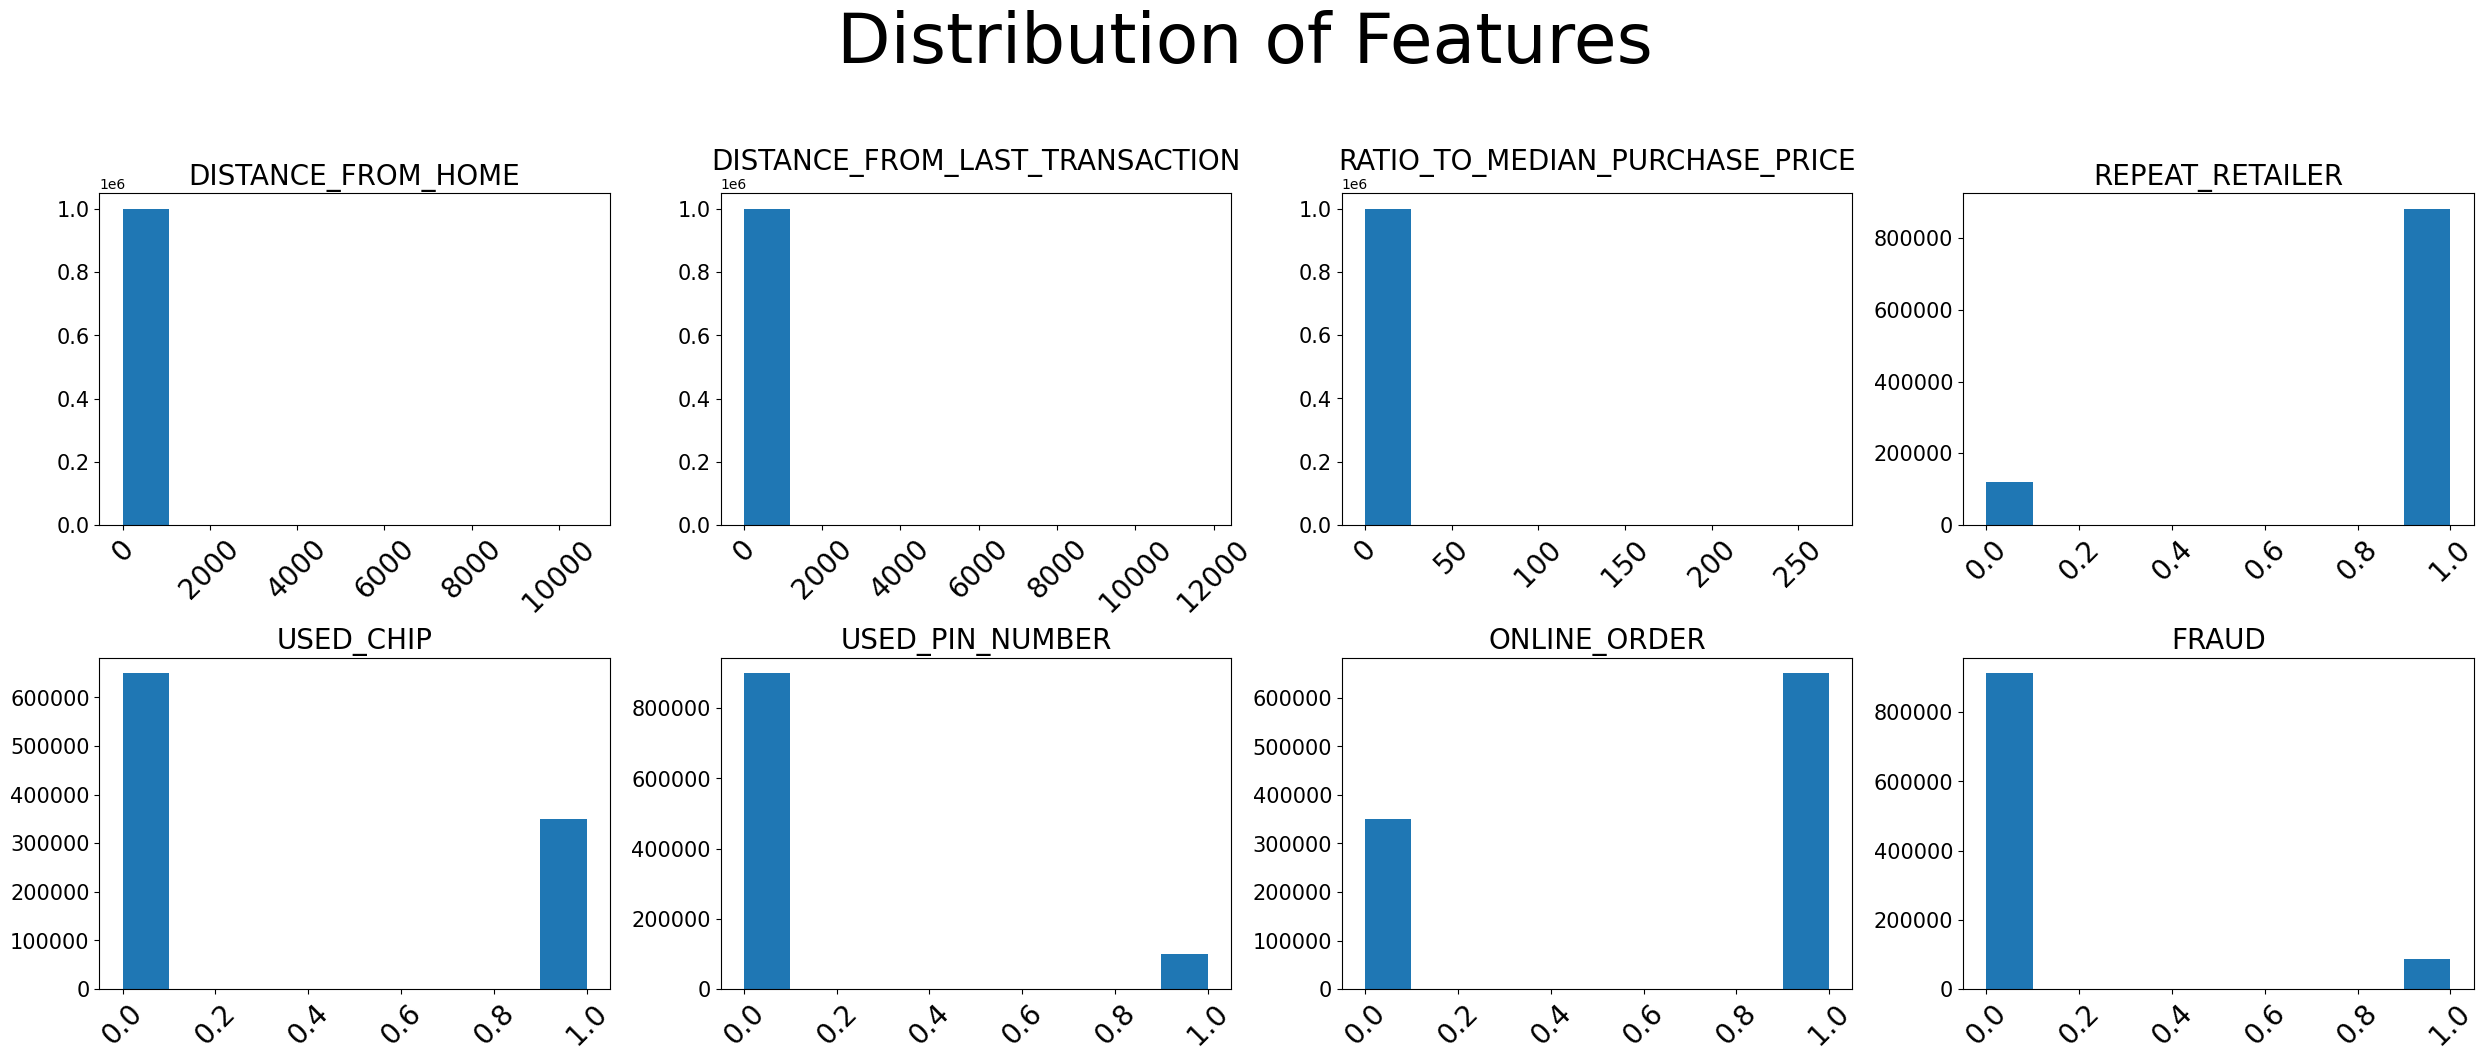

In [81]:
fig = plt.figure(figsize=(25, 15))
st = fig.suptitle("Distribution of Features", fontsize=50, verticalalignment="center")
for col, num in zip(df.toPandas().describe().columns, range(1,11)):
  ax = fig.add_subplot(3,4, num)
  ax.hist(df.toPandas()[col])
  plt.grid(False)
  plt.xticks(rotation=45, fontsize=20)
  plt.yticks(fontsize=15)
  plt.title(col.upper(), fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [82]:
numeric_features = [t[0] for t in df.dtypes if t[1] !='string']
numeric_features_df = df.select(numeric_features)
numeric_features_df.toPandas().head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [83]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])

In [84]:
from pyspark.mllib.stat import Statistics
import pandas as pd

In [85]:
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index = col_names
corr_df.columns = col_names
round(corr_df, 2)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,1.00,0.00,-0.00,0.14,-0.00,-0.0,-0.00,0.19
distance_from_last_transaction,0.00,1.00,0.00,-0.00,0.00,-0.0,0.00,0.09
ratio_to_median_purchase_price,-0.00,0.00,1.00,0.00,0.00,0.0,-0.00,0.46
repeat_retailer,0.14,-0.00,0.00,1.00,-0.00,-0.0,-0.00,-0.00
used_chip,-0.00,0.00,0.00,-0.00,1.00,-0.0,-0.00,-0.06
used_pin_number,-0.00,-0.00,0.00,-0.00,-0.00,1.0,-0.00,-0.10
online_order,-0.00,0.00,-0.00,-0.00,-0.00,-0.0,1.00,0.19
fraud,0.19,0.09,0.46,-0.00,-0.06,-0.1,0.19,1.00


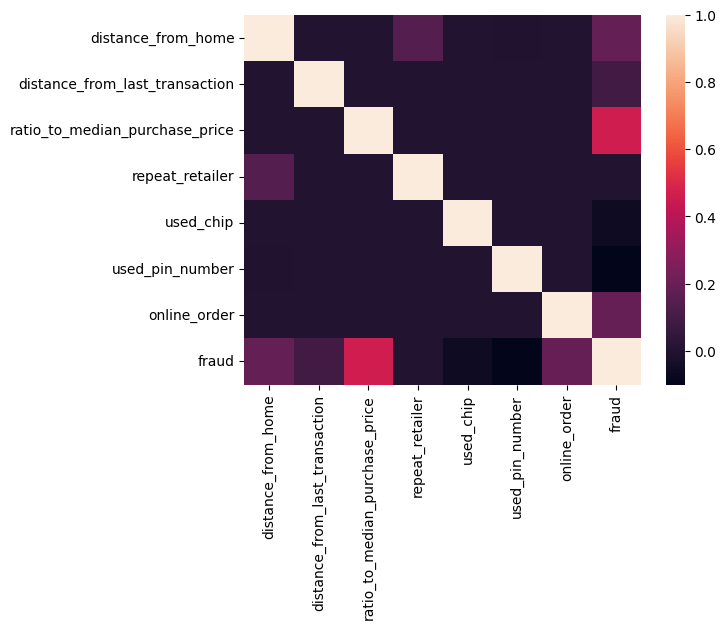

In [86]:
sns.heatmap(corr_df);


### Filter Function

In [87]:
df.filter('fraud=1').show()

+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
|distance_from_home|distance_from_last_transaction|ratio_to_median_purchase_price|repeat_retailer|used_chip|used_pin_number|online_order|fraud|
+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
| 2.131955665990563|              56.3724005365082|             6.358667321630612|            1.0|      0.0|            0.0|         1.0|  1.0|
|3.8030573513256023|             67.24108052618409|            1.8729496143044642|            1.0|      0.0|            0.0|         1.0|  1.0|
|15.694985541059943|            175.98918151972342|            0.8556228290724207|            1.0|      0.0|            0.0|         1.0|  1.0|
|26.711462023719893|            1.5520081259491354|             4.603600688206188|            1.0|      1.0|            0.0|         1.0

In [88]:
df.filter('fraud=1'and'distance_from_home>=15').show()

+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
|distance_from_home|distance_from_last_transaction|ratio_to_median_purchase_price|repeat_retailer|used_chip|used_pin_number|online_order|fraud|
+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
| 57.87785658389723|            0.3111400080477545|            1.9459399775518593|            1.0|      1.0|            0.0|         0.0|  0.0|
| 44.19093600261837|            0.5664862680583477|            2.2227672978404707|            1.0|      1.0|            0.0|         1.0|  0.0|
| 765.2825592612469|            0.3715619621963146|            0.5512447476281009|            1.0|      1.0|            0.0|         0.0|  0.0|
| 179.6651476857078|           0.12091963755751828|            0.5356404825310114|            1.0|      1.0|            1.0|         1.0

### Group By Function

In [89]:
df.groupBy('fraud').count().show()

+-----+------+
|fraud| count|
+-----+------+
|  0.0|912597|
|  1.0| 87403|
+-----+------+



### Checking Correlation

### Linear Regression

In [90]:
from pyspark.ml.feature import VectorAssembler
fs=VectorAssembler(inputCols=['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price','repeat_retailer','used_chip','used_pin_number','online_order'],outputCol="op")

In [91]:
output=fs.transform(df)

In [92]:
output.show()

+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+--------------------+
|distance_from_home|distance_from_last_transaction|ratio_to_median_purchase_price|repeat_retailer|used_chip|used_pin_number|online_order|fraud|                  op|
+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+--------------------+
| 57.87785658389723|            0.3111400080477545|            1.9459399775518593|            1.0|      1.0|            0.0|         0.0|  0.0|[57.8778565838972...|
|10.829942699255545|           0.17559150228166587|            1.2942188106198573|            1.0|      0.0|            0.0|         0.0|  0.0|[10.8299426992555...|
| 5.091079490616996|            0.8051525945853258|           0.42771456119427587|            1.0|      0.0|            0.0|         1.0|  0.0|[5.09107949061699...|
|2.2475643

In [93]:
final=output.select('op','fraud')

In [94]:
final.show()

+--------------------+-----+
|                  op|fraud|
+--------------------+-----+
|[57.8778565838972...|  0.0|
|[10.8299426992555...|  0.0|
|[5.09107949061699...|  0.0|
|[2.24756432829636...|  0.0|
|[44.1909360026183...|  0.0|
|[5.58640767418640...|  0.0|
|[3.72401912471481...|  0.0|
|[4.84824657228056...|  0.0|
|(7,[0,1,2],[0.876...|  0.0|
|[8.83904670372637...|  0.0|
|[14.2635297350690...|  0.0|
|[13.5923675679096...|  0.0|
|[765.282559261246...|  0.0|
|[2.13195566599056...|  1.0|
|[13.9559723670444...|  0.0|
|[179.665147685707...|  0.0|
|[114.519789391612...|  0.0|
|[3.58964859762134...|  0.0|
|[11.0851524840576...|  0.0|
|[6.19467076632605...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [95]:
from pyspark.ml.regression import LinearRegression
train_data,test_data=final.randomSplit([0.70,0.30])
reg=LinearRegression(featuresCol='op',labelCol='fraud')
reg=reg.fit(train_data)

In [96]:
reg.coefficients

DenseVector([0.0009, 0.0009, 0.0473, -0.0273, -0.0367, -0.0947, 0.1139])

In [97]:
reg.intercept

-0.05447671155106893

In [98]:
results=reg.evaluate(test_data)

In [99]:
results.predictions.show()

+--------------------+-----+--------------------+
|                  op|fraud|          prediction|
+--------------------+-----+--------------------+
|(7,[0,1,2],[0.031...|  0.0| 0.06101761750946059|
|(7,[0,1,2],[0.073...|  0.0| 0.09082187126816263|
|(7,[0,1,2],[0.083...|  0.0| -0.0353484207866138|
|(7,[0,1,2],[0.089...|  0.0|0.015666925842021125|
|(7,[0,1,2],[0.093...|  0.0|-0.01203284597430395|
|(7,[0,1,2],[0.098...|  0.0| 0.08987459173702833|
|(7,[0,1,2],[0.105...|  0.0|-0.04249149223451004|
|(7,[0,1,2],[0.108...|  0.0|-0.02988483583587081|
|(7,[0,1,2],[0.114...|  0.0|-0.02726031750379...|
|(7,[0,1,2],[0.121...|  0.0|-0.04776175960424...|
|(7,[0,1,2],[0.136...|  0.0|-0.03137779482058099|
|(7,[0,1,2],[0.141...|  0.0| 0.10948955936938595|
|(7,[0,1,2],[0.143...|  1.0| 0.17087396264315974|
|(7,[0,1,2],[0.154...|  0.0|0.005589340943899769|
|(7,[0,1,2],[0.155...|  0.0|-0.03747467899075...|
|(7,[0,1,2],[0.176...|  0.0|  0.0356032031455383|
|(7,[0,1,2],[0.176...|  0.0|-0.00671811738671...|


In [100]:
print("Coefficients: " + str(reg.coefficients))
print("Intercept: " + str(reg.intercept))

Coefficients: [0.0008733395127606573,0.0009327383312460081,0.0472739565093457,-0.02732777464970568,-0.03665557029525315,-0.09469061627796671,0.11391892657028974]
Intercept: -0.05447671155106893


In [101]:
log_reg = LogisticRegression(labelCol="fraud", featuresCol="op",maxIter=40)
model=log_reg.fit(train_data)

In [102]:
prediction_test=model.transform(test_data)


In [103]:
prediction_test.show()


+--------------------+-----+--------------------+--------------------+----------+
|                  op|fraud|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(7,[0,1,2],[0.031...|  0.0|[8.29260799498093...|[0.99974970199357...|       0.0|
|(7,[0,1,2],[0.073...|  0.0|[7.71087918057513...|[0.99955227305439...|       0.0|
|(7,[0,1,2],[0.083...|  0.0|[10.0550012733542...|[0.99995703154184...|       0.0|
|(7,[0,1,2],[0.089...|  0.0|[8.73908547399062...|[0.99983982533172...|       0.0|
|(7,[0,1,2],[0.093...|  0.0|[9.50329389064810...|[0.99992539988383...|       0.0|
|(7,[0,1,2],[0.098...|  0.0|[7.71579788718167...|[0.99955446890591...|       0.0|
|(7,[0,1,2],[0.105...|  0.0|[10.1853620982593...|[0.99996228300675...|       0.0|
|(7,[0,1,2],[0.108...|  0.0|[9.95802617165456...|[0.99995265614460...|       0.0|
|(7,[0,1,2],[0.114...|  0.0|[9.87805768359060...|[0.99994871483198...|       0.0|
|(7,[0,1,2],[0.1

In [104]:
predictionAndLabels = prediction_test.select("fraud","prediction").rdd


In [105]:
predictionAndLabels.collect()

[Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=1.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=1.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud=0.0, prediction=0.0),
 Row(fraud

In [106]:
evaluator = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="accuracy")
accuracy_LR = evaluator.evaluate(prediction_test)
print ("Accuracy = " ,accuracy_LR)

Accuracy =  0.9586611735648379


### NaiveBayes

In [107]:
naive_bayes = NaiveBayes(featuresCol='op',labelCol='fraud',smoothing=1.0)


In [108]:
model = naive_bayes.fit(train_data) 

In [109]:
prediction_test = model.transform(test_data)


In [110]:
prediction_test.show()


+--------------------+-----+--------------------+--------------------+----------+
|                  op|fraud|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(7,[0,1,2],[0.031...|  0.0|[-8.5575850773450...|[0.79434702980074...|       0.0|
|(7,[0,1,2],[0.073...|  0.0|[-19.105558888827...|[0.72021365140498...|       0.0|
|(7,[0,1,2],[0.083...|  0.0|[-2.3940929305691...|[0.89715214272551...|       0.0|
|(7,[0,1,2],[0.089...|  0.0|[-95.722795007463...|[0.53328428191093...|       0.0|
|(7,[0,1,2],[0.093...|  0.0|[-33.361049823207...|[0.80918941157151...|       0.0|
|(7,[0,1,2],[0.098...|  0.0|[-21.971556518350...|[0.71123902127584...|       0.0|
|(7,[0,1,2],[0.105...|  0.0|[-2.0086709463296...|[0.90247426485603...|       0.0|
|(7,[0,1,2],[0.108...|  0.0|[-2.0610869942949...|[0.89395754324515...|       0.0|
|(7,[0,1,2],[0.114...|  0.0|[-9.7501621539223...|[0.87824216514638...|       0.0|
|(7,[0,1,2],[0.1

In [111]:
prediction_test.select("fraud","prediction").show(10)


+-----+----------+
|fraud|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 10 rows



In [112]:
predictionAndLabels = prediction_test.select("fraud","prediction").rdd


In [113]:
evaluator = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="accuracy")
accuracy_NB = evaluator.evaluate(prediction_test)

In [114]:
print ("Accuracy",accuracy_NB)


Accuracy 0.9204281138825766


### RandomForestClassifier

In [115]:
random_forest_classifier = RandomForestClassifier(labelCol="fraud", featuresCol="op", numTrees=40)


In [116]:
model = random_forest_classifier.fit(train_data)


In [117]:
prediction_test = model.transform(test_data)


In [118]:
prediction_test.show()


+--------------------+-----+--------------------+--------------------+----------+
|                  op|fraud|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(7,[0,1,2],[0.031...|  0.0|[39.6335573151191...|[0.99083893287797...|       0.0|
|(7,[0,1,2],[0.073...|  0.0|[39.6335573151191...|[0.99083893287797...|       0.0|
|(7,[0,1,2],[0.083...|  0.0|[39.6335573151191...|[0.99083893287797...|       0.0|
|(7,[0,1,2],[0.089...|  0.0|[37.2989093295943...|[0.93247273323985...|       0.0|
|(7,[0,1,2],[0.093...|  0.0|[39.6335573151191...|[0.99083893287797...|       0.0|
|(7,[0,1,2],[0.098...|  0.0|[39.6335573151191...|[0.99083893287797...|       0.0|
|(7,[0,1,2],[0.105...|  0.0|[39.6335573151191...|[0.99083893287797...|       0.0|
|(7,[0,1,2],[0.108...|  0.0|[39.6335573151191...|[0.99083893287797...|       0.0|
|(7,[0,1,2],[0.114...|  0.0|[39.6335573151191...|[0.99083893287797...|       0.0|
|(7,[0,1,2],[0.1

In [119]:
prediction_test.select("fraud","prediction").show(10)


+-----+----------+
|fraud|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 10 rows



In [120]:
evaluator = MulticlassClassificationEvaluator( labelCol="fraud", predictionCol="prediction", metricName="accuracy")
accuracy_RF= evaluator.evaluate(prediction_test)

In [121]:
print ("Accuracy",accuracy_RF)


Accuracy 0.9837984732211286


#### Finally we conclude that the Transaction can be flagged fraud based on repeat retailer(paying to same user again),distance from last transactions and whether it is online transaction.